# Нейрон с различными функциями активации

##Задание

В этом задании нужно будет: 
- самостоятельно реализовать класс **`Neuron()`** с различными функциями активации (ReLU, LeakyReLU и ELU)

- обучить и протестировать этот класс на сгенерированных и реальных данных

**Достаточно реализовать ReLU и ещё одну из двух.**

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0). Мы уже выяснили (в ноутбуке про `logloss`), что плохо брать для классификации квадратичную функцию потерь, однако здесь для простоты возьмём её:

$$
Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2
$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $\hat{y_i} = \sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида ($i$ -- номер объекта в выборке). 

In [ ]:
def Loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Далее будут предложены несколько функций активации, и Вам нужно реализовать класс `Neuron` по аналогии с тем, как это было на семинаре. Сам принцип тот же, но меняются формула обновления весов и формула предсказания.

##Нейрон с ReLU (Recitified Linear Unit)  

###О ReLU и реализация нейрона с ReLU

ReLU самая часто используемая (по крайней мере, пару лет назад) функция активации в нейронных сетях. Выглядит она очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В (свободном) переводе Rectified Linear Unit = "Усечённая линейная функция". Собственно, мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

(помните, что $w \cdot X_i$ -- это число в данном случае (результат скалярного произведения двух векторов)).

Тогда формула для обновления весов при градиентном спуске будет такая (в матричном виде, рекмоендуем вывести самим то, как это получается из формулы для одного объекта):

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

(напоминаем, что здесь $w \cdot X$ -- матричное произведение вектора $w$ (ведь вектор -- тоже матрица, не так ли?) и матрицы $X$ )

Почему в первом случае будет 0? Потому что в формулу $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [ ]:
def relu(x):
    """ReLU-функция"""
    return np.where(x <=0, 0, x)

In [ ]:
def relu_derivative(x):
    """Производная ReLU"""
    return np.where(x <= 0, 0, 1)

Теперь нужно написать нейрон с ReLU. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
import time
class NeuronReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b).reshape(-1, 1)
        return y_pred
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        calc_w = np.zeros((X.shape[1], 1))
        calc_b = 0.

        for i in range(len(X)):
            calc_w = calc_w + relu_derivative(y_pred[i]) * X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
            calc_b += relu_derivative(y_pred[i])*(y_pred[i][0] - y[i][0])
        self.w = self.w - learning_rate * (calc_w / n)
        self.b = self.b - learning_rate * calc_b / n    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        if self.w is None:
          self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
          self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        t0 = 0
        for i in range(num_epochs):
            time_start = time.time()
            if i % 1000 == 0:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Прошло эпох:", i, "Общее время выполнения:",minutes,"минут", t0 - (minutes * 60), "секунд")
            y_pred = self.forward_pass(X)
            Loss_values.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
            t0 = t0 + time.time() - time_start
            if i == num_epochs - 1:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Прошло эпох:", i, "Общее время выполнения:", minutes,"минут", t0 - (minutes * 60), "секунд")
              print("Время выполнения при num_epochs =", num_epochs, ":", minutes,"минут", t0 - (minutes * 60), "секунд")
        
        return Loss_values
    def predict(self, X, div):
      return np.array(self.forward_pass(X) > div).ravel()

### Тестирование нейрона с ReLU  

Здесь вам нужно самим протестировать новый нейрон **на тех же данных** ("Яблоки и Груши" и "Голос") по аналогии с тем, как это было проделано с перцептроном.
В итоге нужно вывести: 
* график, на котором будет показано, как изменяется функция потерь $Loss$ в зависимости от числа итераций обучения
* график с раскраской выборки нейроном

***ПРИМЕЧАНИЕ***: пожалуйста, почаще проверяйте `.shape` у матриц и векторов: `self.w`, `X` и `y` внутри класса. Очень часто ошибка решается транспонированием или `.reshape()`'ом. Не забывайте проверять, что на что Вы умножаете и какой вектор (какой размер) хотите получить на выходе -- это очень помогает не запутаться.

####Проверка forward_pass():

Зададим значения $w = [2, 1]$ и $b = 2$

In [ ]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X = np.array([[1., 2., -1.], [3., 4., -3.2]])

NLL = NeuronReLU(w, b)
y_pred = NLL.forward_pass(X.T)
print ("y_pred = " + str(y_pred))

y_pred = [[ 9.]
 [12.]
 [ 0.]]


####Проверка backward_pass():

In [ ]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [ ]:
NLL.backward_pass(X.T, y, y_pred)

print ("w = " + str(NLL.w))
print ("b = " + str(NLL.b))

w = [[0.94666667]
 [1.88      ]]
b = [1.96666667]


#### Тестирование нейрона с ReLU: Яблоки и груши

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data/apples_pears.csv')
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

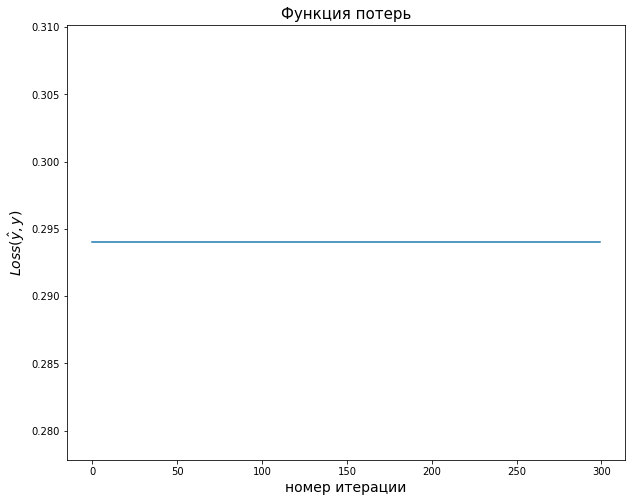

CPU times: user 7.07 s, sys: 536 ms, total: 7.61 s
Wall time: 7.1 s


In [ ]:
%%time
neuron = NeuronReLU()
Loss_values = neuron.fit(X, y)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Скорее всего сейчас у вас лосс -- это прямая линия, и вы видите, что веса не обновляются. Но почему?

Всё просто -- если присмотреться, то видно, что self.w и self.b иницилизируются нулями в начале `.fit()`-метода. Если расписать, как будет идти обновление, то видно, что из-за ReLU веса просто-напросто не будут обновляться, если начать с инициализации нулями. 

Это -- одна из причин, по которой в нейронных сетях веса инициализируют случаными числами (обычно из отрезка [0, 1)).

Обучите нейрон, инициализировав случайно веса (поставьте 10000 итераций). 

Закомментируйте инициализацию нулями в функции `.fit()` класса `NeuronReLU` 

Прошло эпох: 0 Общее время выполнения: 0 минут 0 секунд
Прошло эпох: 1000 Общее время выполнения: 0.0 минут 23.000582218170166 секунд
Прошло эпох: 2000 Общее время выполнения: 0.0 минут 46.78404235839844 секунд
Прошло эпох: 3000 Общее время выполнения: 1.0 минут 10.355239868164062 секунд
Прошло эпох: 4000 Общее время выполнения: 1.0 минут 33.69036388397217 секунд
Прошло эпох: 5000 Общее время выполнения: 1.0 минут 56.738248348236084 секунд
Прошло эпох: 6000 Общее время выполнения: 2.0 минут 20.379145622253418 секунд
Прошло эпох: 7000 Общее время выполнения: 2.0 минут 43.783074378967285 секунд
Прошло эпох: 8000 Общее время выполнения: 3.0 минут 7.460560083389282 секунд
Прошло эпох: 9000 Общее время выполнения: 3.0 минут 31.56103205680847 секунд
Прошло эпох: 9999 Общее время выполнения: 3.0 минут 54.4216685295105 секунд
Время выполнения при num_epochs = 10000 : 3.0 минут 54.4216685295105 секунд


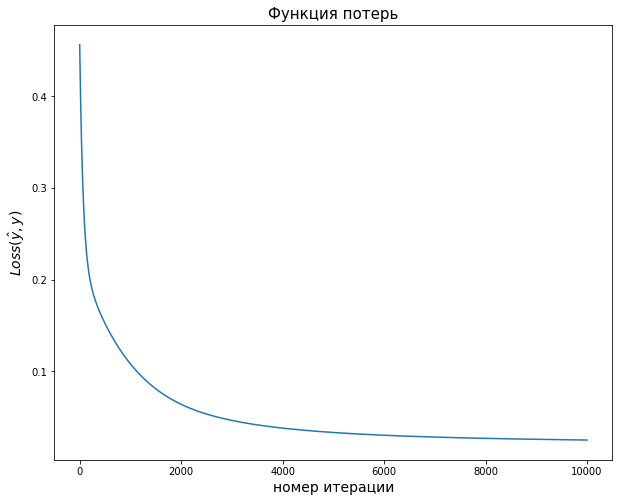

In [ ]:
neuron = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Посмотрим, как предсказывает этот нейрон:

Best accuracy score:  0.985  if division =  0.65


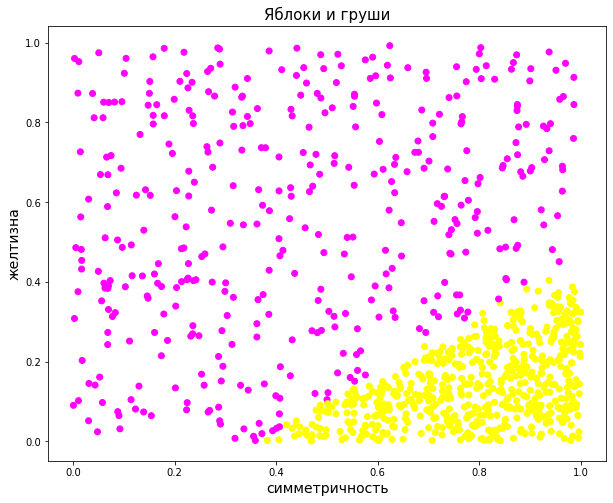

In [ ]:
from sklearn.metrics import accuracy_score
best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y, neuron.predict(X, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))
division = max(best)[1]
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=neuron.predict(X, division), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show()

#### Тестирование нейрона с ReLU: Голос

Прошло эпох: 0 Общее время выполнения: 0 минут 0 секунд
Прошло эпох: 1000 Общее время выполнения: 1.0 минут 19.391806602478027 секунд
Прошло эпох: 2000 Общее время выполнения: 2.0 минут 39.55070614814758 секунд
Прошло эпох: 3000 Общее время выполнения: 3.0 минут 58.96972703933716 секунд
Прошло эпох: 4000 Общее время выполнения: 5.0 минут 18.73078942298889 секунд
Прошло эпох: 4999 Общее время выполнения: 6.0 минут 37.840617418289185 секунд
Время выполнения при num_epochs = 5000 : 6.0 минут 37.840617418289185 секунд


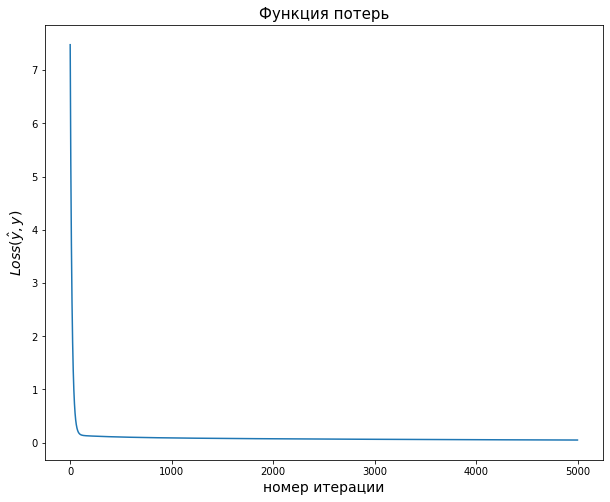

Best accuracy score:  0.8969505783385909  if division =  0.48


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv('/content/drive/MyDrive/data/voice.csv')
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)
data_cols = data.columns.values
min_max_scaler = MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data_cols)
data = data.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data.drop("label", axis=1), data.label, train_size = 0.7, random_state=42)
neuron = NeuronReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1)[0])
loss_values = neuron.fit(X_train.values, y_train.values.reshape(-1, 1), num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y_test, neuron.predict(X_test.values, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))

Есть одна тенденция: пороговая функция активации и сигмоида (обычно всё же только сигмоида) чаще используются именно на **выходном слое** нейросети в задаче классификации -- ими предсказывают вероятности объектов принадлежать одному из классов, в то время как продвинутые функции активации (ReLU и те, что будут дальше) используются внутри нейросети, то есть в **скрытых слоях**.

Нужно понимать, что ReLU не может вернуть отрицательные числа.

**Плюсы ReLU:**

* дифференцируемая (с доопределе
нием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде

**Возможные минусы ReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* зануляет все отрицательные входы, тем самым веса у занулённых нейронов могут часто *не обновляться*, эту проблему иногда называют *мёртвые нейроны*

С последней проблемой можно побороться, а именно:

##Нейрон с LeakyReLU (Leaky Recitified Linear Unit)  

###О LeakyReLU и реализация нейрона с LeakyReLU

LeakyReLU очень слабо отличается от ReLU, но часто помогает сети обучаться быстрее, поскольку нет проблемы "мёртвых нейронов":

\begin{equation*}
LeakyReLU(x) =
 \begin{cases}
   \alpha x, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
LeakyReLU'(x) = 
 \begin{cases}
   \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

График этой функции:

<img src="https://cdn-images-1.medium.com/max/1600/0*UtLlZJ80TMIM7kXk." width=400 height=300>

Подставим LeakyReLu в Loss:

$$
Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (LeakyReLU(w \cdot X_i) - y_i)^2 =
\begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha \cdot w \cdot X_i - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}
$$  

Формула для обновления весов при градиентном спуске:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   \alpha X_i^T (w \cdot X_i - y), &{w \cdot X_i \le 0}\\
    X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте LeakyReLU и её производную:

In [ ]:
def leaky_relu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.where(x <= 0, alpha * x, x)

In [ ]:
def leaky_relu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return np.where(x <= 0, alpha, 1)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronLeakyReLU:
    def __init__(self, w=None, b=0, alpha=0.01):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        self.alpha = alpha
        
        
    def activate(self, x):
        return leaky_relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b).reshape(-1,1)
        return y_pred
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        calc_w = np.zeros((X.shape[1], 1))
        calc_b = 0.
        for i in range(len(X)):
            calc_w = calc_w + leaky_relu_derivative(y_pred[i]) * X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
            calc_b += leaky_relu_derivative(y_pred[i]) * (y_pred[i][0] - y[i][0])
        self.w = self.w - learning_rate * (calc_w / n)
        self.b = self.b - learning_rate * calc_b/n
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        if self.w is None:
          self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
          self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        t0 = 0
        for i in range(num_epochs):
            time_start = time.time()
            if i % 1000 == 0:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Прошло эпох:", i, "Общее время выполнения:",minutes,"минут", t0 - (minutes * 60), "секунд")
            y_pred = self.forward_pass(X)
            Loss_values.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
            t0 = t0 + time.time() - time_start
            if i == num_epochs - 1:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Прошло эпох:", i, "Общее время выполнения:", minutes,"минут", t0 - (minutes * 60), "секунд")
              print("Время выполнения при num_epochs =", num_epochs, ":", minutes,"минут", t0 - (minutes * 60), "секунд")        
        return Loss_values
    def predict(self, X, div):
      return np.array(self.forward_pass(X) > div).ravel()


###Тестирование нейрона с LeakyReLU

####Проверка forward_pass():

Зададим значения $w = [2, 1]$ и $b = 2$

In [ ]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X = np.array([[1., 2., -1.], [3., 4., -3.2]])

NLL = NeuronLeakyReLU(w, b)
y_pred = NLL.forward_pass(X.T)
print ("y_pred = " + str(y_pred))

y_pred = [[ 9.   ]
 [12.   ]
 [-0.054]]


####Проверка backward_pass():

In [ ]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [ ]:
NLL.backward_pass(X.T, y, y_pred)

print ("w = " + str(NLL.w))
print ("b = " + str(NLL.b))

w = [[0.9466491 ]
 [1.87994379]]
b = [1.96668423]


####Тестирование нейрона с LeakyReLU: Яблоки и груши

Прошло эпох: 0 Общее время выполнения: 0 минут 0 секунд
Прошло эпох: 1000 Общее время выполнения: 0.0 минут 20.026317596435547 секунд
Прошло эпох: 2000 Общее время выполнения: 0.0 минут 39.92268967628479 секунд
Прошло эпох: 3000 Общее время выполнения: 1.0 минут 0.07076859474182129 секунд
Прошло эпох: 4000 Общее время выполнения: 1.0 минут 20.729518175125122 секунд
Прошло эпох: 5000 Общее время выполнения: 1.0 минут 41.236621379852295 секунд
Прошло эпох: 6000 Общее время выполнения: 2.0 минут 1.4199490547180176 секунд
Прошло эпох: 7000 Общее время выполнения: 2.0 минут 21.608485221862793 секунд
Прошло эпох: 8000 Общее время выполнения: 2.0 минут 41.544220209121704 секунд
Прошло эпох: 9000 Общее время выполнения: 3.0 минут 1.7391529083251953 секунд
Прошло эпох: 9999 Общее время выполнения: 3.0 минут 21.858100175857544 секунд
Время выполнения при num_epochs = 10000 : 3.0 минут 21.858100175857544 секунд


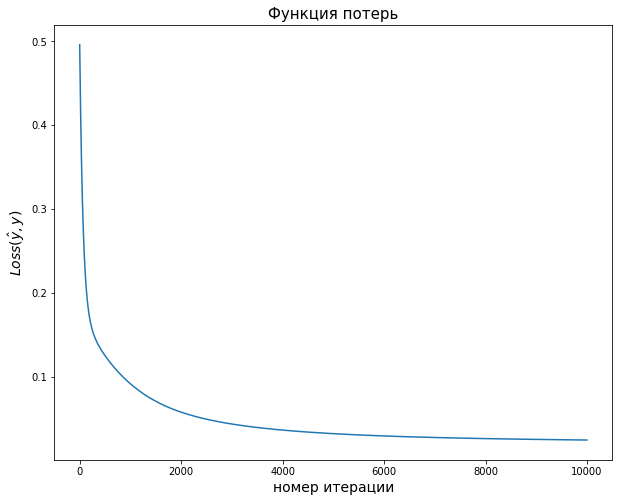

Best accuracy score:  0.983  if division =  0.65


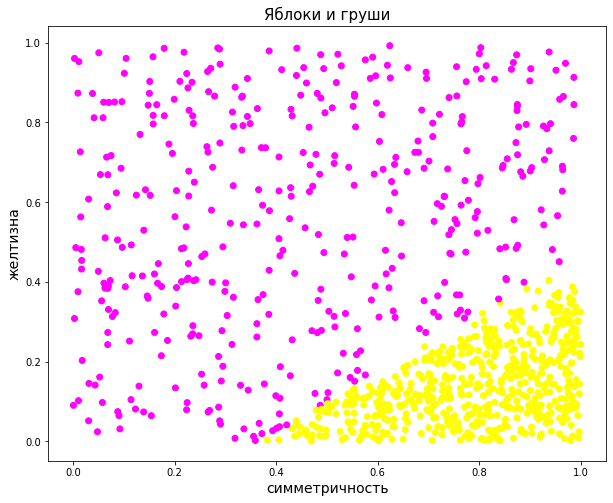

In [ ]:
from sklearn.metrics import accuracy_score
data = pd.read_csv('/content/drive/MyDrive/data/apples_pears.csv')
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)
neuronL= NeuronLeakyReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values_L = neuronL.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values_L)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y, neuronL.predict(X, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))
division = max(best)[1]
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=neuronL.predict(X, division), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show()



####Тестирование нейрона с LeakyReLU: Голос

Прошло эпох: 0 Общее время выполнения: 0 минут 0 секунд
Прошло эпох: 1000 Общее время выполнения: 1.0 минут 18.78947877883911 секунд
Прошло эпох: 2000 Общее время выполнения: 2.0 минут 36.8490846157074 секунд
Прошло эпох: 3000 Общее время выполнения: 3.0 минут 55.0661039352417 секунд
Прошло эпох: 4000 Общее время выполнения: 5.0 минут 13.192409992218018 секунд
Прошло эпох: 4999 Общее время выполнения: 6.0 минут 30.72373652458191 секунд
Время выполнения при num_epochs = 5000 : 6.0 минут 30.72373652458191 секунд


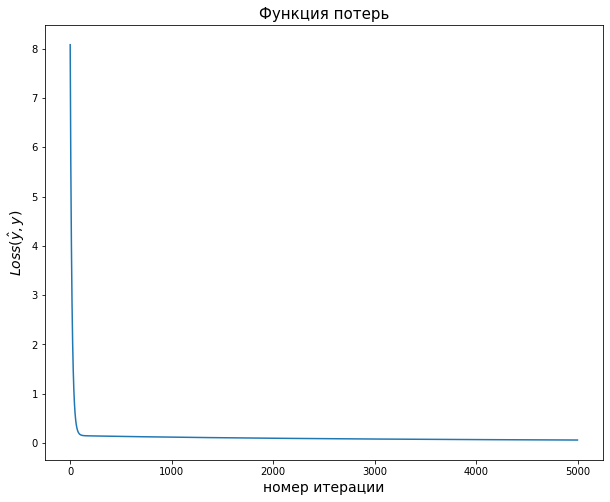

Best accuracy score:  0.8937960042060988  if division =  0.44


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv('/content/drive/MyDrive/data/voice.csv')
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)
data_cols = data.columns.values
min_max_scaler = MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data_cols)
data = data.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data.drop("label", axis=1), data.label, train_size = 0.7, random_state=42)
neuron_L = NeuronLeakyReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1)[0])
loss_values_L = neuron_L.fit(X_train.values, y_train.values.reshape(-1, 1), num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(loss_values_L)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y_test, neuron_L.predict(X_test.values, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))

**Плюсы LeakyReLU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU

**Возможные минусы LeakyReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* немного не устойчива к "шуму" (см. лекции Стэнфорда)

##Нейрон с ELU (Exponential Linear Unit)</a></b></h2>  

###О ELU и реализация нейрона с ELU

ELU -- не так давно предложенная (в 2015 году) функция активации, которая, как говорят авторы статьи, лучше LeakyReLU. Вот формула ELU:

\begin{equation*}
ELU(\alpha, x) =
 \begin{cases}
   \alpha (e^x - 1), &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
ELU'(x) = 
 \begin{cases}
   ELU(\alpha, x) + \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Здесь в производной использован постой трюк -- сделано $- \alpha + \alpha$, чтобы вычислять было проще.

График этой функции:

<img src="http://p0.ifengimg.com/pmop/2017/0907/A004001DD141881BFD8AD62E5D31028C3BE3FAD1_size14_w446_h354.png" width=500 height=400>

Подставим ELU в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ELU(\alpha, w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha (e^{w \cdot X_i} - 1) - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Здесь вам нужно выписать самим град спуск для весов. Брать производную "в лоб" некрасиво и неудобно. Нужно воспользоваться **правилом цепочки**, оно же **правило взятия производной сложной функции**:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   X_i^T(ELU(\alpha, w \cdot X_i) + \alpha) (ELU(\alpha, w \cdot X_i)+\alpha - y_i), &{w \cdot X_i \le 0}\\
   X_i^T(w \cdot X_i - y_i) , &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$
* Реализуйте ELU и её производную:

In [ ]:
def elu(x, alpha=0.01):
    """ELU-функция"""
    return np.where(x > 0, x, alpha*(np.exp(x) - 1))

In [ ]:
def elu_derivative(x, alpha=0.01):
    """Производная ELU"""
    return np.where(x > 0, 1, elu(x, alpha=alpha) + alpha)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronELU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return elu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b).reshape(-1,1)
        return y_pred
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        calc_w = np.zeros((X.shape[1], 1))
        calc_b = 0.
        for i in range(len(X)):
          if y_pred[i] > 0:
            calc_w = calc_w + X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
            calc_b += (y_pred[i][0] - y[i][0])
          else:
            calc_w = calc_w + elu_derivative(y_pred[i]) * X[i].reshape(1, -1).T @ (elu_derivative(y_pred[i]).reshape(1, 1) - y[i].reshape(1, 1))
            calc_b += elu_derivative(y_pred[i]) *(elu_derivative(y_pred[i])[0] - y[i][0])
        self.w = self.w - learning_rate * (calc_w / n)
        self.b = self.b - learning_rate * calc_b/n
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        if self.w is None:
          self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
          self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        t0 = 0
        for i in range(num_epochs):
            time_start = time.time()
            if i % 1000 == 0:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Прошло эпох:", i, "Общее время выполнения:",minutes,"минут", t0 - (minutes * 60), "секунд")
            y_pred = self.forward_pass(X)
            Loss_values.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
            t0 = t0 + time.time() - time_start
            if i == num_epochs - 1:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Прошло эпох:", i+1, "Общее время выполнения:", minutes,"минут", t0 - (minutes * 60), "секунд")
              print("Время выполнения при num_epochs =", num_epochs, ":", minutes,"минут", t0 - (minutes * 60), "секунд")        
        return Loss_values
    def predict(self, X, div):
      return np.array(self.forward_pass(X) > div).ravel()

###Тестирование нейрона с ELU

####Проверка forward_pass():

Зададим значения $w = [2, 1]$ и $b = 2$

In [ ]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X = np.array([[1., 2., -1.], [3., 4., -3.2]])

NLL = NeuronELU(w, b)
y_pred = NLL.forward_pass(X.T)
print ("y_pred = " + str(y_pred))

y_pred = [[ 9.00000000e+00]
 [ 1.20000000e+01]
 [-9.95483419e-03]]


####Проверка backward_pass():

In [ ]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [ ]:
NLL.backward_pass(X.T, y, y_pred)

print ("w = " + str(NLL.w))
print ("b = " + str(NLL.b))

w = [[0.94665033]
 [1.87994772]]
b = [1.966683]


####Тестирование нейрона с ELU: Яблоки и груши

Прошло эпох: 0 Общее время выполнения: 0 минут 0 секунд
Прошло эпох: 1000 Общее время выполнения: 0.0 минут 7.865063667297363 секунд
Прошло эпох: 2000 Общее время выполнения: 0.0 минут 18.761871814727783 секунд
Прошло эпох: 3000 Общее время выполнения: 0.0 минут 32.201759576797485 секунд
Прошло эпох: 4000 Общее время выполнения: 0.0 минут 47.62225270271301 секунд
Прошло эпох: 5000 Общее время выполнения: 1.0 минут 4.103711128234863 секунд
Прошло эпох: 6000 Общее время выполнения: 1.0 минут 21.550360202789307 секунд
Прошло эпох: 7000 Общее время выполнения: 1.0 минут 40.02058124542236 секунд
Прошло эпох: 8000 Общее время выполнения: 1.0 минут 59.60539650917053 секунд
Прошло эпох: 9000 Общее время выполнения: 2.0 минут 20.015962839126587 секунд
Прошло эпох: 10000 Общее время выполнения: 2.0 минут 40.833877086639404 секунд
Время выполнения при num_epochs = 10000 : 2.0 минут 40.833877086639404 секунд


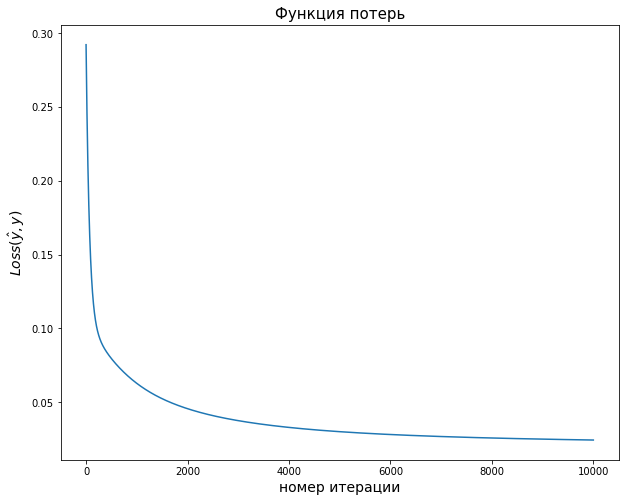

Best accuracy score:  0.988  if division =  0.65


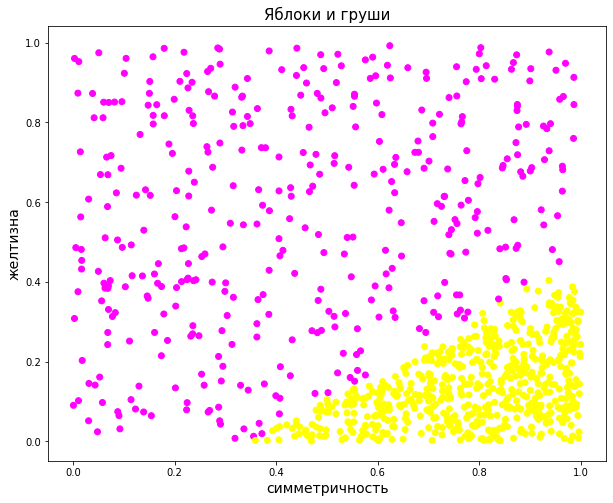

In [ ]:
from sklearn.metrics import accuracy_score
data = pd.read_csv('/content/drive/MyDrive/data/apples_pears.csv')
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)
neuron_elu = NeuronELU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values_elu = neuron_elu.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values_elu)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y, neuron_elu.predict(X, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))
division = max(best)[1]
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=neuron_elu.predict(X, division), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show()



####Тестирование нейрона с ELU: Голос

Прошло эпох: 0 Общее время выполнения: 0 минут 0 секунд
Прошло эпох: 1000 Общее время выполнения: 0.0 минут 54.92115497589111 секунд
Прошло эпох: 2000 Общее время выполнения: 1.0 минут 53.02497386932373 секунд
Прошло эпох: 3000 Общее время выполнения: 2.0 минут 51.92045831680298 секунд
Прошло эпох: 4000 Общее время выполнения: 3.0 минут 52.59669804573059 секунд
Прошло эпох: 5000 Общее время выполнения: 4.0 минут 55.20624756813049 секунд
Время выполнения при num_epochs = 5000 : 4.0 минут 55.20624756813049 секунд


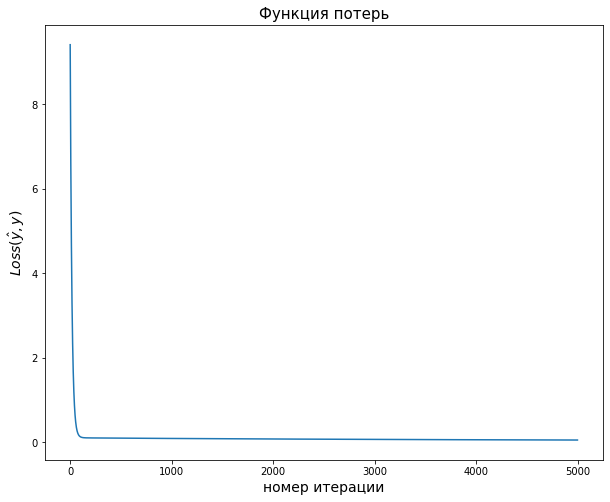

Best accuracy score:  0.8937960042060988  if division =  0.51


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv('/content/drive/MyDrive/data/voice.csv')
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)
data_cols = data.columns.values
min_max_scaler = MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data_cols)
data = data.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data.drop("label", axis=1), data.label, train_size = 0.7, random_state=42)
neuron_elu = NeuronELU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1))
loss_values_elu = neuron_elu.fit(X_train.values, y_train.values.reshape(-1, 1), num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(loss_values_elu)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y_test, neuron_elu.predict(X_test.values, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))

**Плюсы ELU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU
* более устойчива к "шуму" (см. лекции Стэнфорда)

**Возможные минусы ELU:**

* не очень хорошо центрирована около 0 (может мешать скорости сходимсти)
* вычислительно дольше, чем ReLU и LeakyReLU